# Обучение обобщающего NN-классификатора новообразований молочной железы

- [train/val/test разбивка](#train/val/test-разбивка)
- [Конвертация из DataFrame в Dataset](#Конвертация-из-DataFrame-в-Dataset)
- [Модель](#Модель)

In [1]:
import os

import tensorflow as tf

from utils import neural_network as nn
from utils import definitions as defs
from utils import visualization as viz

### Конвертация из DataFrame в Dataset

In [2]:
tf.config.experimental.set_visible_devices([], 'GPU')  # отключаю GPU, так как оно у меня слабое и не даёт преимущества

In [3]:
entire_ds = nn.dataset_from_csv(defs.ENTIRE_DATA_PATH)
train_ds = nn.dataset_from_csv(defs.TRAIN_DATA_PATH)
val_ds = nn.dataset_from_csv(defs.VAL_DATA_PATH)
test_ds = nn.dataset_from_csv(defs.TEST_DATA_PATH)

## Модель

In [4]:
model = nn.create_model(128, entire_ds)

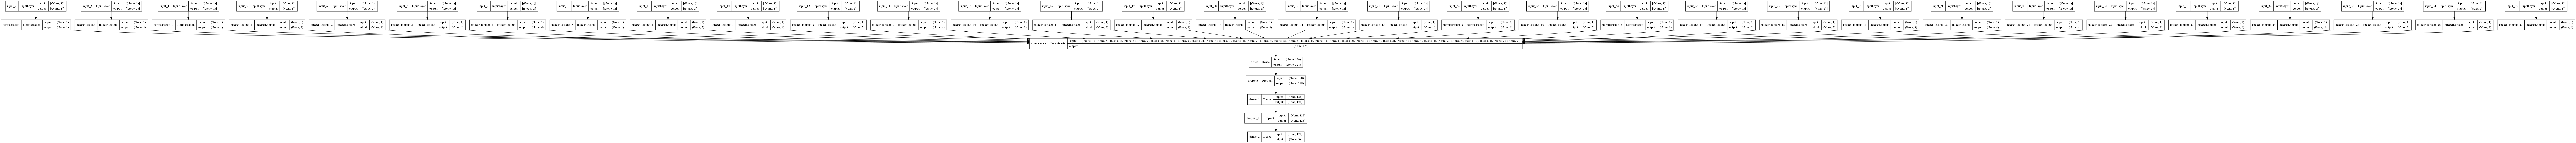

In [5]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, rankdir='TB', dpi=100)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
NUM_EPOCHS = 300


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=defs.GENERALIZING_MODEL,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_ds, epochs=NUM_EPOCHS, verbose=0, callbacks=callbacks_list, validation_data=val_ds)

INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets
INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\generalizing model\assets


In [8]:
model.save(defs.OVERFITTED_MODEL)

INFO:tensorflow:Assets written to: E:\Projects\Breast-Cancer\models\overfitted model\assets


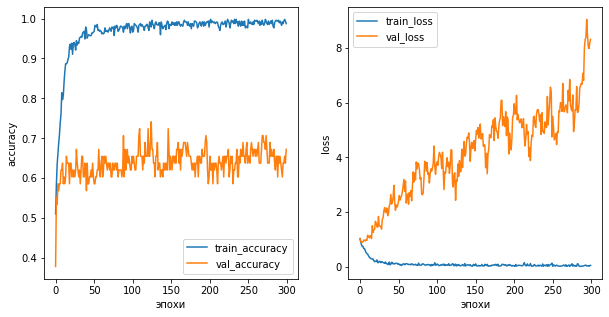

In [9]:
viz.plot_history(history)